### Determining optimal threshold
12.3.24

Testing all of the possible threshold values between 0 and 1.0 for hoop and mulch based on our training data

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#### Importing data

In [2]:
# import datasets
train_path = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/"
wv_csv = train_path + 'Watsonville_val_BM_P95.csv'
ox_csv = train_path + 'Oxnard_all_P95.csv'
sm_csv = train_path + 'SantaMaria_val_o_P95.csv'
wv = pd.read_csv(wv_csv)
ox = pd.read_csv(ox_csv)
sm = pd.read_csv(sm_csv)

# # earlier era when I had created individual year + region samples

# # Santa Maria
# sm_csv = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/thresholding/SantaMaria_val_o_withPlasticProbs_p95.csv'
# sm = pd.read_csv(sm_csv)

# # Watsonville (training)
# wv_csv = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/thresholding/Watsonville_Points_BM_withPlasticProbs_p95_WY2022.csv'
# wv = pd.read_csv(wv_csv)

# # Oxnard 
# ox_csv = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/thresholding/Oxnard_Points_withPlasticProbs_p95_WY2022.csv'
# ox = pd.read_csv(ox_csv)
# # Convert 'blackmulch' to 'mulch' in the 'Type' column
# ox['Type'] = ox['Type'].replace('blackmulch', 'mulch')

# # Watsonville (random points)
# wr_csv = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/thresholding/Wats_RandomPoints_GE2021.csv'
# wr = pd.read_csv(wr_csv)
# # Convert name of column from Name to Type
# wr.rename(columns={'Name': 'Type'}, inplace=True)

# # Watsonville (training) WY 2021
# wv_csv21 = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/thresholding/Watsonville_Points_BM_withPlasticProbs_p95_WY2021.csv'
# wv_21 = pd.read_csv(wv_csv21)
# wv_21.drop(columns=['hoop_p95', 'mulch_p95'], inplace=True)
# wv_21.rename(columns={'hoop_p95_WY21': 'hoop_p95', 'mulch_p95_WY21': 'mulch_p95'}, inplace=True)

# print("Unique values in 'Type' column for Santa Maria dataset:", sm['Type'].unique())
# print("Unique values in 'Type' column for Watsonville dataset:", wv['Type'].unique())
# print("Unique values in 'Type' column for Oxnard dataset:", ox['Type'].unique())
# print("Unique values in 'Type' column for Wats Random dataset:", wr['Type'].unique())

# Define which dataset to use
# data = ox
# data = pd.concat([ox, wv, sm], ignore_index=True)
# data = wv_21
# data = pd.concat([ox, wv, sm, wr, wv_21], ignore_index=True)

data = pd.concat([ox, wv, sm], ignore_index=True)


In [3]:
print(f"Number of rows: {data.shape[0]}")
data.head()
data.dropna(subset=['hoop'], inplace=True)
print(f"Number of rows after removing null values: {data.shape[0]}")
# print(f"Number of rows with null values in 'hoop' column: {data['hoop'].isnull().sum()}")
# print(f"Number of rows with null values in 'mulch' column: {data['mulch'].isnull().sum()}")

Number of rows: 4091
Number of rows after removing null values: 3618


#### Comparing mulch and hoop confusion

If we take points that are classified as both mulch and hoop based on whatever thresholds we design, 
it will work most of the time. When a point is classified higher as mulch, it is mulch. 
There is some confusion:

- In Santa Maria, before thresholding, this approach would misclassify hoop as mulch 1.3% of the time, and misclassify mulch as hoop 7.4% of the time
- In Watsonville, before thresholding, this approach misclassifies hoop as mulch 0.6% of the time, and misclassifies mulch as hoop 0 times
- In Oxnard, no confusion
- Overall, 1% of hoop points would be misclassified as mulch and 2% of mulch points would be misclassified as hoop

In [4]:
# filter to hoop points
hoop = data[data['Type'] == 'hoop']
# will have to change column name back to 'hoop_p95' if I use the older datasets
hoop_count = hoop[hoop['hoop'] > hoop['mulch']].shape[0]
mulch_count = hoop[hoop['mulch'] > hoop['hoop']].shape[0]

if hoop_count == 0: # oxnard has no hoop points in 2022
    print('No points classified as "hoop":')
else:
    print('Of the points that are classified as "hoop"')
    print(f"Hoop count: {hoop_count}")
    print(f"Mulch count: {mulch_count}")
    print(f'Confusion rate: {(mulch_count / (hoop_count + mulch_count))*100:.2f}%')

mulch = data[data['Type'] == 'mulch']
hoop_count = mulch[mulch['hoop'] > mulch['mulch']].shape[0]
mulch_count = mulch[mulch['mulch'] > mulch['hoop']].shape[0]

print('Of the points that are classified as "mulch":')
print(f"Hoop count: {hoop_count}")
print(f"Mulch count: {mulch_count}")
print(f'Confusion rate: {(hoop_count / (hoop_count + mulch_count))*100:.2f}%')


Of the points that are classified as "hoop"
Hoop count: 924
Mulch count: 13
Confusion rate: 1.39%
Of the points that are classified as "mulch":
Hoop count: 229
Mulch count: 880
Confusion rate: 20.65%


#### Test the threshold combinations with the highest accuracy

In [8]:
# Function to calculate the accuracy for given thresholds based on our rules
def calculate_accuracy(thresholds, data):
    mulch_threshold, hoop_threshold = thresholds
    correct_classifications = 0
    other_weight = 0.5 # between 0 and 1
    
    for _, row in data.iterrows():
        # 
        if row['Type'] == 'mulch' and row['mulch'] >= mulch_threshold and (
            # test if hoop is no or if mulch has a greater distance above its threshold than hoop
            row['hoop'] < hoop_threshold or (row['hoop'] - hoop_threshold) < (row['mulch'] - mulch_threshold)):
            # row['hoop'] < hoop_threshold or row['hoop'] < row['mulch']): # old way
            correct_classifications += 1
        elif row['Type'] == 'hoop' and row['hoop'] >= hoop_threshold and (
            row['mulch'] < mulch_threshold or (row['mulch'] - mulch_threshold) < (row['hoop'] - hoop_threshold)):
            # row['mulch'] < mulch_threshold or row['mulch'] < row['hoop']): # old way
            correct_classifications += 1
        elif row['Type'] == 'other' and row['mulch'] < mulch_threshold and row['hoop'] < hoop_threshold:
            # correct_classifications += 1
    # return correct_classifications / len(data)
            correct_classifications += other_weight
    other_count = data[data['Type'] == 'other'].shape[0]
    subtract = other_count * (1 - other_weight)
    return correct_classifications / (len(data) - subtract)

# Define the range of thresholds to test
thresholds_range = np.arange(0.0, 1.05, 0.05)

# Initialize variables to store the best thresholds and highest accuracy
best_thresholds = (0, 0)
highest_accuracy = 0
accuracy_table = pd.DataFrame(columns=['mulch_threshold', 'hoop_threshold', 'accuracy'])

# Iterate over all possible combinations of thresholds
for mulch_threshold in thresholds_range:
    for hoop_threshold in thresholds_range:
        accuracy = calculate_accuracy((mulch_threshold, hoop_threshold), data)
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_thresholds = (mulch_threshold, hoop_threshold)
        accuracy_row = pd.DataFrame({'mulch_threshold': [mulch_threshold], 'hoop_threshold': [hoop_threshold], 'accuracy': [accuracy]})
        accuracy_table = pd.concat([accuracy_table, accuracy_row], ignore_index=True)

print(f"Best thresholds: Mulch: {best_thresholds[0]}, Hoop: {best_thresholds[1]:.2f}")
print(f"Highest accuracy: {highest_accuracy*100:.2f}%")
# Sort the accuracy table by highest accuracy first
accuracy_table = accuracy_table.sort_values(by='accuracy', ascending=False)
display(accuracy_table.head(10))

E:\Users\annalise.taylor\AppData\Local\Temp\58\ipykernel_54868\1794133900.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracy_table = pd.concat([accuracy_table, accuracy_row], ignore_index=True)


Best thresholds: Mulch: 0.45, Hoop: 0.55
Highest accuracy: 77.13%


,mulch_threshold,hoop_threshold,accuracy
200,0.45,0.55,0.771326
201,0.45,0.60,0.769613
222,0.50,0.60,0.767386
199,0.45,0.50,0.765331
223,0.50,0.65,0.763275
178,0.40,0.50,0.762761
221,0.50,0.55,0.762590
179,0.40,0.55,0.761220
202,0.45,0.65,0.760021
177,0.40,0.45,0.754368


#### Resulting thresholds

**With the test for hoop/mulch confusion:**
- In Santa Maria, it's Mulch 0.5 and Hoop 0.75 (91% accurate)
- In Watsonville, it's Mulch 0.05 and Hoop 0.05 (81% accurate)
- In Oxnard, it's Mulch 0.45 and Hoop 0.35 (96% accurate)
- Watsonville random points, it's Mulch 0.7 and Hoop 0.65 (87% accurate)
- Watsonville 2021 - mulch 0.05, hoop 0.75 (83%)

Overall for training data from 2022, it's Mulch 0.45 and Hoop 0.75 (86% accurate)

Overall (training data 2022, wr, wv_21), it's mulch 0.35 and hoop 0.75 (79% accurate)

**Without the inter-plastic confusion test:**
- In Santa Maria, it's Mulch 0.5 and Hoop 0.5 (93% accurate)
- In Watsonville, it's the same - Mulch 0.05 and Hoop 0.05 (81% accurate)
- In Oxnard, it's the same -  Mulch 0.45 and Hoop 0.35 (96% accurate)
- Watsonville grid, it's the same
- Watsonville 2021 - mulch 0.05, hoop 0.05 (85%)

Overall for training data from 2022, it's Mulch 0.45 and Hoop 0.70 (86% accurate)

Overall (training data 2022, wr, wv_21), it's mulch 0.35 and hoop 0.50 (80% accurate)

#### Add predicted value to the dataframe

In [6]:
def add_classification_col(row):
    mulch_threshold = 0.5
    hoop_threshold = 0.6
    
    if row['mulch'] >= mulch_threshold and (
        # test if hoop is no or if mulch has a greater distance above its threshold than hoop
        row['hoop'] < hoop_threshold or (row['hoop'] - hoop_threshold) < (row['mulch'] - mulch_threshold)):
        return 'mulch'
    elif row['hoop'] >= hoop_threshold and (
        row['mulch'] < mulch_threshold or (row['mulch'] - mulch_threshold) < (row['hoop'] - hoop_threshold)):
        return 'hoop'
    elif row['mulch'] < mulch_threshold and row['hoop'] < hoop_threshold:
        return 'other'
    else:
        return 'unknown'
    

data['classifier'] = data.apply(add_classification_col, axis=1)

In [8]:
data

,Unnamed: 0,Date,Location,Type,Latitude,Longitude,class,hoop_wy2019,mulch_wy2019,hoop_wy2020,...,mulch_wy2021,hoop_wy2022,mulch_wy2022,hoop_wy2023,mulch_wy2023,pDate,WY,hoop,mulch,classifier
0,2,2019-10-14,Oxnard,hoop,34.189033,-119.123641,0,0.840154,0.319122,0.947812,...,0.258826,0.268048,0.525986,0.560886,0.629096,2019-10-14,2020,0.947812,0.375856,hoop
1,3,2023-05-06,Oxnard,hoop,34.149149,-119.106545,0,0.938303,0.714899,0.922347,...,0.662342,0.907179,0.439560,0.943741,0.348104,2023-05-06,2023,0.943741,0.348104,hoop
2,5,2019-10-14,Oxnard,hoop,34.189348,-119.121985,0,0.720913,0.317242,0.948622,...,0.288076,0.280236,0.399099,0.450626,0.751348,2019-10-14,2020,0.948622,0.401897,hoop
3,7,2019-10-14,Oxnard,hoop,34.189332,-119.121210,0,0.829229,0.435291,0.967717,...,0.213748,0.283907,0.413552,0.482375,0.478937,2019-10-14,2020,0.967717,0.576993,hoop
4,8,2019-10-14,Oxnard,hoop,34.189376,-119.124074,0,0.691087,0.287913,0.919275,...,0.224670,0.330585,0.423846,0.513560,0.550766,2019-10-14,2020,0.919275,0.299097,hoop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,975,2021-02-06,Santa Maria,mulch,34.990410,-120.497203,1,NaN,NaN,NaN,...,0.901058,0.690013,0.965978,0.482038,0.941054,2021-02-06,2021,0.865644,0.901058,mulch
4087,976,2021-02-06,Santa Maria,mulch,34.990676,-120.501473,1,NaN,NaN,NaN,...,0.880900,0.661807,0.968106,0.784111,0.941054,2021-02-06,2021,0.869406,0.880900,mulch
4088,977,2021-02-06,Santa Maria,mulch,34.989570,-120.501519,1,NaN,NaN,NaN,...,0.879694,0.654533,0.963333,0.528931,0.830627,2021-02-06,2021,0.854824,0.879694,mulch
4089,978,2021-02-06,Santa Maria,mulch,34.990623,-120.502547,1,NaN,NaN,NaN,...,0.872859,0.654184,0.966435,0.643140,0.970884,2021-02-06,2021,0.853687,0.872859,mulch


#### Make a confusion matrix

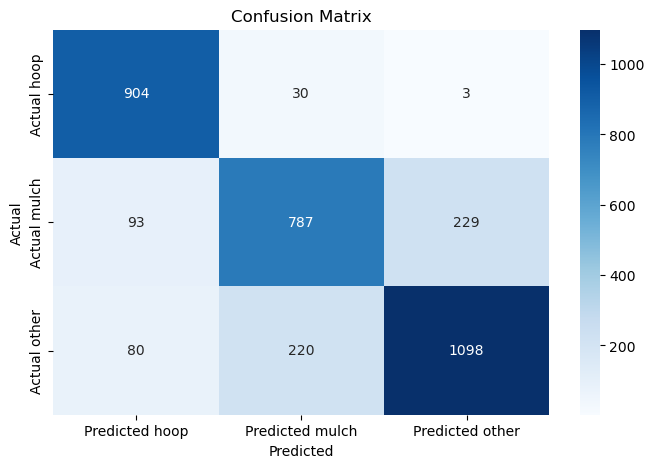

In [ ]:
y_true = data['Type']
y_pred = data['classifier']

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['hoop', 'mulch', 'other'])

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['Actual hoop', 'Actual mulch', 'Actual other'], columns=['Predicted hoop', 'Predicted mulch', 'Predicted other'])

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

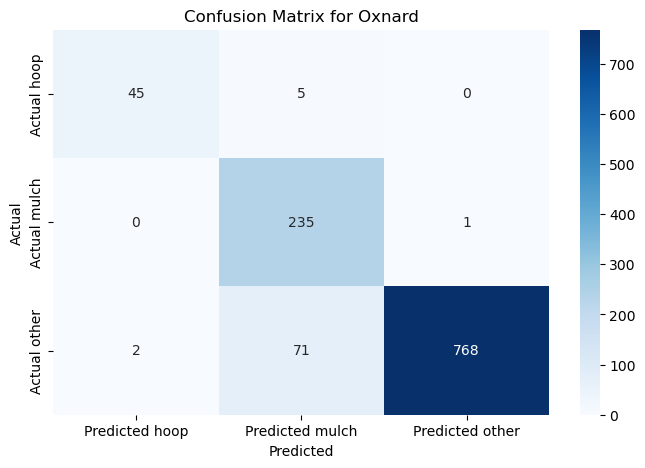

Accuracy for Oxnard: 92.99%


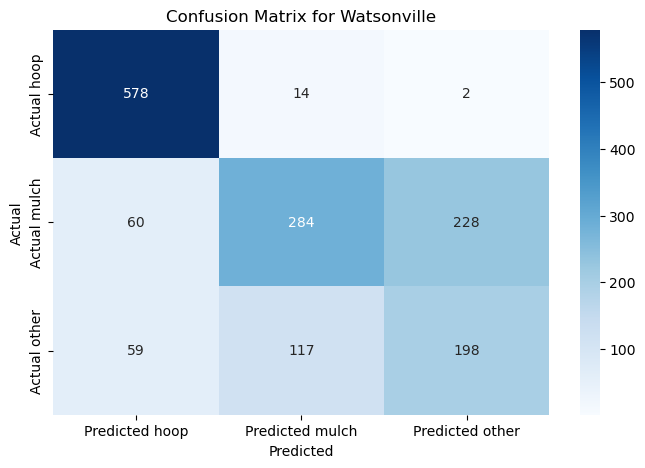

Accuracy for Watsonville: 68.83%


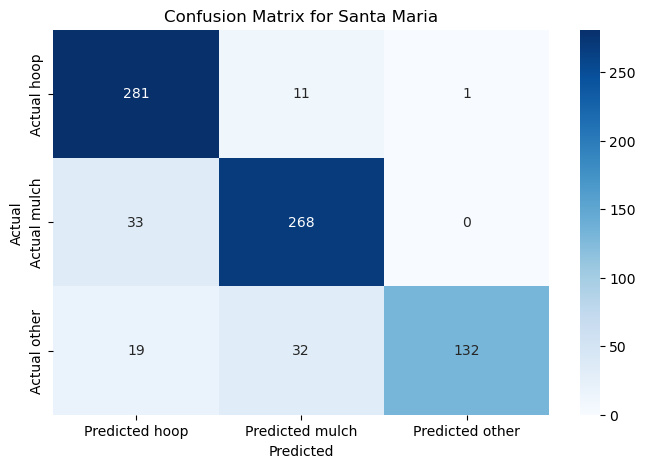

Accuracy for Santa Maria: 87.64%


In [11]:
# Create confusion matrices for each unique location
unique_locations = data['Location'].unique()

for location in unique_locations:
    location_data = data[data['Location'] == location]
    y_true_loc = location_data['Type']
    y_pred_loc = location_data['classifier']
    
    # Create confusion matrix
    cm_loc = confusion_matrix(y_true_loc, y_pred_loc, labels=['hoop', 'mulch', 'other'])
    
    # Create a DataFrame for better visualization
    cm_loc_df = pd.DataFrame(cm_loc, index=['Actual hoop', 'Actual mulch', 'Actual other'], columns=['Predicted hoop', 'Predicted mulch', 'Predicted other'])
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm_loc_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {location}')
    plt.show()
    
    # Calculate and print accuracy
    accuracy_loc = np.trace(cm_loc) / np.sum(cm_loc)
    print(f"Accuracy for {location}: {accuracy_loc*100:.2f}%")